# CODE: Code for Optimizing Docking Enrichments

In [1]:
######Importa los paquetes necesarios
%pylab inline

import csv, os, random, sys, shutil
from emcee_code import emcee_code_function, modelo

#rc('text', usetex=True, fontsize=20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
ResultsDatabase=genfromtxt('Input.csv', delimiter=',') #[[0,0]]
ndxchg=0

In [3]:
Nombre='test'
inputfile='Input.csv' 

numParam=3
mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

numTrainMol=105
semilla=1
thresAct=1 #Por debajo (o igual) a este valor se considera el compuesto activo

coluAct=2
coluMIC=3
coluMICcal=4

iterac=500
aviso=50

pesot=5
thresComp=25
descrp=0
ndxchg=0

#iterac2=100
#########################################################################################################################

#if os.path.exists(Nombre)==True:
#    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
#if os.path.exists(Nombre)==False:
#    os.mkdir(Nombre)

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'In.csv' )
Datos=genfromtxt(Nombre + '/'+Nombre+'In.csv', delimiter=',', skip_header=1) 

In [4]:
filasTrain=[]
TrainSet=zeros((numTrainMol, len(Datos[0,:])))
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

matriz_propiedades = Datos[:,len(Datos[0,:])-1-numParam:(len(Datos[0,:])-1)]
mic = Datos[:,coluMIC]

for i in range(len(Datos[0,:])):
    random.seed(semilla)
    filasTrain=random.sample(range(len(Datos[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(Datos[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=Datos[j,:]
        ndx+=1   

        
for i in range(0, len(Datos[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)

ndx=0
for k in range(0, len(Datos[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=Datos[k,:]
        ndx += 1

## MonteCarlo

In [5]:
print shape(mic[:30])

(30,)


In [6]:
print shape(matriz_propiedades[:30,:])

(30, 3)


Mean acceptance fraction: 0.587 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
('alfa1 = ', array([-67.90604734,  -0.77453882,  -0.3117571 ]))
('alfa2 = ', array([ -1.57664839,  -1.07112273,  15.08589767]))
('alfa3 = ', array([-24.19896583,   0.051101  ,   0.45223675]))


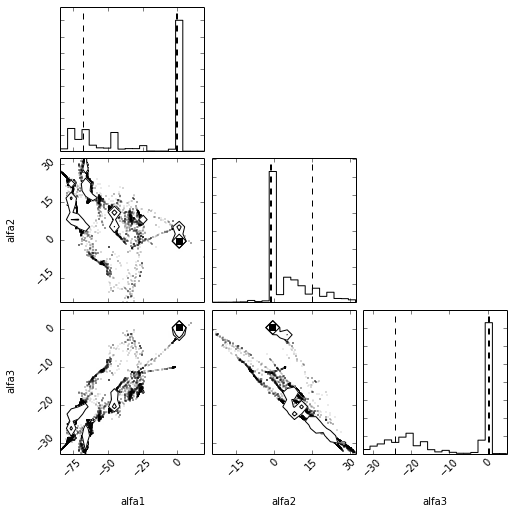

In [7]:
parametros_emcee = emcee_code_function(matriz_propiedades[:30,:], mic[:30], semilla)

parametros_sin_error = parametros_emcee[:,1]

(0, 30)

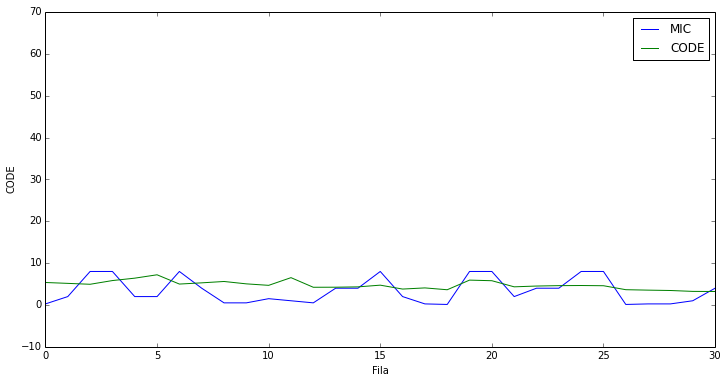

In [8]:
figure(figsize = (12,6))
plot(mic, label='MIC')
plot(modelo(matriz_propiedades, parametros_sin_error), label='CODE')
legend()
xlabel('Fila')
ylabel('CODE')
xlim(0,30)